# Exploring the dynamics of timeseries data with timecorr
*Written by Jeremy Manning*

The [timecorr](https://timecorr.readthedocs.io/en/latest/) Python toolbox provides tools for computing and exploring the correlational structure of timeseries data.  The details of this approach are described in [this preprint](https://www.biorxiv.org/content/10.1101/763821v1); some excerpts from the methods of that paper are reproduced below for convenience.

In its most basic usage, the `timecorr` function provided by the toolbox takes as input a number-of-timepoints ($T$) by number-of-features ($K$) matrix, and returns as output a $K \times K \times T$ tensor containing a timeseries of the moment-by-moment correlations reflected in the data.  There are two additional special features of the timecorr toolbox that we'll also explore in this tutorial: dynamic inter-subject functional correlations and high-order dynamic correlations.  Before explaining those additional features, we'll expand on how timecorr estimates dynamic correlations from multi-dimensional timeseries data.

Given a $T$ by $K$ matrix of observations, $\mathbf{X}$, we can compute the (static) Pearson's correlation between any pair of columns, $\mathbf{X}(\cdot, i)$ and $\mathbf{X}(\cdot, j)$ using:

$$
\begin{align}
  \mathrm{corr}(\mathbf{X}(\cdot, i), \mathbf{X}(\cdot, j)) &=\frac{\sum_{t=1}^T \left(\mathbf{X}(t,i) - \bar{\mathbf{X}}(\cdot,i)\right) \left(\mathbf{X}(t, - \bar{\mathbf{X}}(\cdot, j)\right)}{\sqrt{\sum_{t=1}^T \sigma^2_{\mathbf{X}(\cdot, i)} \sigma^2_{\mathbf{X}(\cdot,j)}}},~\mathrm{where}\label{eqn:corr}\\
  \bar{\mathbf{X}}(\cdot, k) &= \frac{1}{T}\sum_{t=1}^T \mathbf{X}(t, k),~\mathrm{and}\\
  \sigma^2_{\mathbf{X}(\cdot, k)} &= \frac{1}{T}\sum_{t=1}^T \left( \mathbf{X}(t, k) - \bar{\mathbf{X}}(\cdot, k) \right)^2
\end{align}
$$

We can generalize this formula to compute time-varying correlations by incorporating a *kernel function* that takes a time $t$ as input, and returns how much the observed data at each timepoint $\tau \in \left[ -\infty, \infty \right]$ contributes to the estimated instantaneous correlation at time $t$.

Given a kernel function $\kappa_t(\cdot)$ for timepoint $t$, evaluated at timepoints $\tau \in \left[ 1, ..., T \right]$, we can update the static correlation formula above to estimate the *instantaneous correlation* at timepoint $t$:

$$
\begin{align}
  \mathrm{timecorr}_{\kappa_t}\left(\mathbf{X}(\cdot, i), \mathbf{X}(\cdot, j)\right) &= \frac{\sum_{\tau=1}^T \left( \mathbf{X}(\tau, i) -
                                       \widetilde{\mathbf{X}}_{\kappa_t}(\cdot,
                                                                                        i) \right)
                                 \left( \mathbf{X}(\tau, j) -
                                        \widetilde{\mathbf{X}}_{\kappa_t}(\cdot,
                                                                                        j)\right)}
              {\sqrt{\sum_{\tau=1}^T
                                              \widetilde{\sigma}_{\kappa_t}^2(\mathbf{X}(\cdot,
                                                                                        i))
                                              \widetilde{\sigma}_{\kappa_t}^2(\mathbf{X}(\cdot, j))}},~\mathrm{where}\label{eqn:timecorr}\\
  \widetilde{\mathbf{X}}_{\kappa_t}(\cdot, k) &= \sum_{\tau=1}^T
                       \kappa_t(\tau)\mathbf{X}(\tau, k),~\mathrm{and}\\
  \widetilde{\sigma}_{\kappa_t}^2(\mathbf{X}(\cdot, k)) &= \sum_{\tau=1}^T
                                                  \left(
                                                  \mathbf{X}(\tau, k) -
                            \widetilde{\mathbf{X}}_{\kappa_t}(\cdot, k) \right)^2.
\end{align}
$$

Here
$\mathrm{timecorr}_{\kappa_t}(\mathbf{X}(\cdot, i), \mathbf{X}(\cdot,
j))$ reflects the correlation at time $t$ between columns $i$ and $j$
of $\mathbf{X}$, estimated using the kernel $\kappa_t$.  We evaluate
the timecorr equation in turn for each pair of columns in
$\mathbf{X}$ and for kernels centered on each timepoint in the
timeseries, respectively, to obtain a $K \times K \times T$ timeseries of
dynamic correlations, $\mathbf{Y}$.

## Dynamic inter-subject functional correlations (dISFC)

Given a multi-subject dataset, [Simony et al. (2016)](https://www.nature.com/articles/ncomms12141.pdf) define a measure of stimulus-driven inter-regional correlations called inter-subject functional correlation (ISFC).  The timecorr toolbox extends this idea to compute a timeseries of ISFC matrices from a multi-subject dataset.  (The original ISFC approach computes a static ISFC matrix, although the authors of the original study use a sliding window approach to approximate a timeseries.)

## Dynamic high-order functional correlations

The image below summarizes a variety of neural patterns that one could (in principle) compute or estimate from a neural dataset.  Within-brain analyses are carried out within a single brain, whereas across-brain analyses compare neural patterns across two or more individuals' brains.  Univariate analyses characterize the activities of individual units (e.g., nodes, small networks, hierarchies of networks, etc.), whereas multivariate analyses characterize the patterns of activities across units.  Order 0 patterns involve individual nodes; order 1 patterns involve node-node interactions; order 2 (and higher) patterns relate to interactions between homologous networks.  Each of these patterns may be static (e.g., averaging over time) or dynamic.

![500px](../../images/timecorr/patterns.jpg)

Computing high-order functional correlations naively would be computationally intractable for even modest numbers of nodes (brain regions) and orders.  This is because the resulting patterns at each timepoint scale exponentially with the order of interactions one attempts to investigate.  To make the computations tractable, we use the so-called [kernel trick](https://towardsdatascience.com/the-kernel-trick-c98cdbcaeb3f) popularized in classification approaches.  Rather than carrying out the computations in the "native" feature space (i.e., exponential scaling), we first project the data onto a much lower dimensional space (with $K$ dimensions), and then we perform the key computations in the low-dimensional space.  This enables us to achieve linear scaling with the order of functional correlations, at the expense of precision (since low-dimensional embeddings are lossy).  We primarily use two approaches for "embedding" the high-dimensional dynamic correlations in a $K$-dimensional space:

![400px](../../images/timecorr/reduce.jpg)

*Dimensionality reduction* approaches take the $\mathcal{O}(K^2)$ patterns and embed them in a $K$-dimensional space that preserves (to the extent possible) the relations between the patterns at different timepoints.  *Graph measure* approaches forgo attempts to preserve the original activity patterns in favor of instead preserving each node's changing positions within the broader network (with respect to other nodes).

An overview of the timecorr approach, along with a summary of some of the key findings from [this paper](https://www.biorxiv.org/content/10.1101/763821v1) may be found in this video (credit: [Lucy Owen](https://lucywowen.github.io/); recording of a talk she gave at Indiana University).

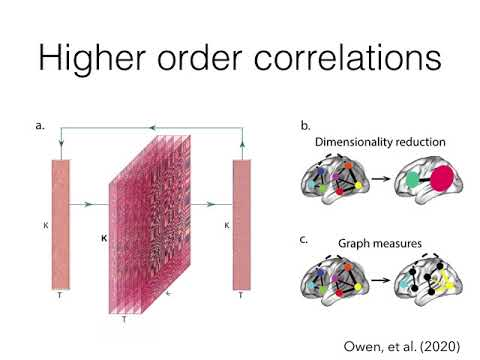

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('y1HYFXVJ5to')

# Getting Started
Before getting started with this tutorial, we need to make sure you have the necessary software installed and data downloaded.

## Software
This tutorial requires the following Python packages to be installed. See the [Software Installation](http://naturalistic-data.org/features/notebooks/Software.html) tutorial for more information.

- seaborn
- matplotlib
- bokeh
- holoviews
- numpy
- pandas
- nltools
- datalad

Let's now load the modules we will be using for this tutorial.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
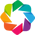

In [8]:
import os
from glob import glob as lsdir
import numpy as np
import pandas as pd
from nltools.mask import create_sphere, expand_mask
from nltools.data import Brain_Data, Adjacency
from nilearn.plotting import plot_stat_map

import timecorr as tc
import seaborn as sns
import holoviews as hv
from holoviews import opts, dim

from bokeh.io import curdoc
from bokeh.layouts import layout
from bokeh.models import Slider, Button
from bokeh.embed import file_html
from bokeh.resources import CDN
import panel as pn
import IPython
import datalad.api as dl

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
hv.extension('bokeh')
hv.output(size=200)

## Data
This tutorial will be using the **Sherlock** dataset and will require downloading the Average ROI **csv** files.

We have already extracted the data for you to make this easier and have written out the average activity within each ROI into a separate csv file for each participant. If you would like to get practice doing this yourself, here is the code we used. Note that we are working with the hdf5 files as they load much faster than the nifti images, but either one will work for this example.

``` python
for scan in ['Part1', 'Part2']:
    file_list = glob.glob(os.path.join(data_dir, 'fmriprep', '*', 'func', f'*crop*{scan}*hdf5'))
    for f in file_list:
        sub = os.path.basename(f).split('_')[0]
        print(sub)
        data = Brain_Data(f)
        roi = data.extract_roi(mask)
        pd.DataFrame(roi.T).to_csv(os.path.join(os.path.dirname(f), f"{sub}_{scan}_Average_ROI_n50.csv" ), index=False)
```

You will want to change `datadir` to wherever you have installed the Sherlock datalad repository. We will initialize a datalad dataset instance and get the files we need for this tutorial. If you've already downloaded everything, this cell should execute quickly. See the [Download Data Tutorial](http://naturalistic-data.org/features/notebooks/Download_Data.html) for more information about how to install and use datalad.

In [10]:
datadir = '/Volumes/Engram/Data/Sherlock'

# If dataset hasn't been installed, clone from GIN repository
if not os.path.exists(datadir):
    dl.clone(source='https://gin.g-node.org/ljchang/Sherlock', path=datadir)

# Initialize dataset
ds = dl.Dataset(datadir)

# Get Cropped & Denoised CSV Files
result = ds.get(lsdir(os.path.join(datadir, 'fmriprep', '*', 'func', f'*Average_ROI*csv')))

# A region of interest-based approach to inferring dynamic correlations

To speed up our computations and make the final results easier to visualize, we'll use timecorr to estimate connectivity patterns between regions of interest, rather than between the original voxels.  Following the [Functional Alignment](http://naturalistic-data.org/features/notebooks/Functional_Alignment.html) tutorial, we'll use a 50-ROI mask.

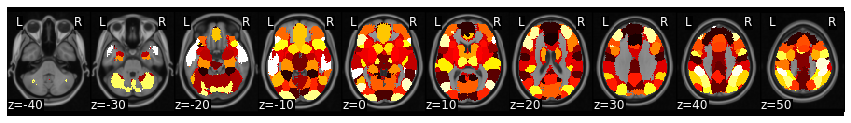

In [11]:
mask = Brain_Data('https://neurovault.org/media/images/8423/k50_2mm.nii.gz')
vectorized_mask = expand_mask(mask)
mask.plot()

In [12]:
rois = pd.read_csv('https://raw.githubusercontent.com/naturalistic-data-analysis/tutorial_development/master/hypertools/rois.csv', header=None, names=['ID', 'Region'])
rois.head()

ID                          Region
0   0                   Anterior MPFC
1   1        Fusiform/parahippocampus
2   2                           DMPFC
3   3  Sensorimotor/postcentral gyrus
4   4                              V1

Next, we'll extract the mean activation patterns within each ROI.

In [13]:
sub_list = [os.path.basename(x).split('_')[0] for x in lsdir(os.path.join(datadir, 'fmriprep', '*', 'func', '*Part1*csv'))]
sub_list.sort()

sub_timeseries = []
for sub in sub_list:
    sub_timeseries.append(np.array(pd.read_csv(os.path.join(datadir, 'fmriprep', sub, 'func', f'{sub}_Part1_Average_ROI_n50.csv'))))
data = {'part 1': sub_timeseries}

In [14]:
def array2df(x, rois):
    def safequery(i):
        if i in rois['ID'].values:
            try:
                return rois.query(f'ID == {i}')['Region'].values[0]
            except:
                print(f'error processing ID: {i}')
        else:
            return ''
    df = pd.DataFrame(x, columns=[safequery(i) for i in np.arange(x.shape[1])])
    df.drop(labels=[''], inplace=True, axis='columns')
    return df

In [15]:
part1 = [array2df(x, rois) for x in data['part 1']]

#print out a few rows from a sample dataframe
part1[0].head()

Anterior MPFC  Fusiform/parahippocampus     DMPFC  \
0       1.755921                  5.826709  1.881618   
1       0.215231                  3.223925  0.318326   
2       1.249452                  4.600020  1.738919   
3      -2.558629                  0.388236 -0.604157   
4      -1.600927                  0.792098 -1.058557   

   Sensorimotor/postcentral gyrus         V1  \
0                        3.776599   8.665937   
1                        1.034115   6.734484   
2                       -0.285278  10.010041   
3                       -2.239837   4.732418   
4                       -3.124524   4.884841   

   TPJ posterior supra marginal/angular gyrus  PCC/precuneus  Thalamus  \
0                                    4.075354       2.421694  2.864211   
1                                    2.424592      -2.547924 -2.290534   
2                                    3.080377      -3.444986 -1.887590   
3                                    0.037954      -4.747537  0.111611   
4                                   -0.203100      -4.648347 -2.059925   

        SMA  Precentral gyrus  ...        A1  Ventral anterior insula  \
0  2.704671          1.684665  ...  8.479704                 2.271374   
1  0.777762         -0.346779  ...  6.601288                -0.166975   
2 -0.490452          1.301151  ...  7.870970                 1.996753   
3 -1.536647         -0.761406  ...  1.653554                -2.125545   
4 -2.232909          0.407795  ...  1.352045                -1.673176   

   Superior LOC  Cerebellum (crus)     DLPFC  Right IFG VLPFC  Inferior LOC  \
0      4.367660           1.004956  0.914738         3.266528      4.668272   
1     -0.095155          -0.048363 -0.783906         1.443243      1.621159   
2     -0.195372          -1.385071  0.495036         3.470111      4.277213   
3     -3.647326          -0.437495 -2.373295        -0.043069      0.717843   
4     -4.333806          -2.170690 -1.767852         1.203035      2.995660   

   Right motor  Somatosensory       STS  
0     4.707671      -0.345977  0.681969  
1     1.516929      -0.990622  0.175821  
2    -0.890185      -2.802245  2.090336  
3    -2.727891      -1.339336 -0.180019  
4    -1.785924      -2.892011 -1.251224  

[5 rows x 41 columns]

## Generate a dISFC timeseries

To generate a timeseries of inter-subject functional correlations, we can use the `timecorr` function as follows.  Note that the `batch_extract_roi` function defined above drops unlabeled ROIs, so we are left with 41 regions from the original set of 50:

In [16]:
isfc = tc.timecorr(part1, cfun=tc.isfc, combine=tc.corrmean_combine)

There are a few things to note here.  The `timecorr` function takes as input a numpy array, pandas DataFrame, or a mixed list of arrays and DataFrames.  By default, `timecorr` treats each data matrix (i.e., array or DataFrame) independently.  For example, calling
```
tc.timecorr(part1)
```
returns a list of arrays, each containing a timeseries of correlations for each participant.

The `cfun` argument specifies which columns (of which matrices) are correlated.  By default, `cfun` is set to `tc.wcorr`, which computes the dynamic correlations between the features in each column of the data matrices.  By setting `cfun` to `tc.isfc`, `timecorr` will compute the dynamic correlations between each column of each participant's data matrix and the average columns of all *other* participants' data matrices.

The `combine` argument specifies how the result is handled.  By default, `combine` is set to `tc.null_combine`, which leaves each participants' timeseries of correlations as separate matrices.  When we set `combine` to `tc.corrmean_combine`, the resulting timeseries of correlations are averaged together to create a single ISFC timeseries.

Finally, note the dimensions of the result.  We input a list of $T \times K$ matrices, and we received a single $T \times [(K^2 - K)/2 + K]$ matrix as output.  Since each timepoint's correlation matrix is symmetric, `timecorr` automatically saves memory by reshaping the upper triangle and diagonal of each timepoint's $K \times K$ correlation matrix into a $[(K^2 - K)/2 + K]$-dimensional vector.  We can recover the $K \times K$ matrices at each timepoint by using the `tc.vec2mat` function, and we can revert back to the compact form using `tc.mat2vec`.

In [17]:
print(f'T = {part1[0].shape[0]}')
print(f'K = {part1[0].shape[1]}')
print(f'Shape of output: (T x [(K^2 - K)/2 + K]) = {isfc.shape}')
print(f'Shape of vec2mat(output): (K x K x T) = {tc.vec2mat(isfc).shape}')
print(f'Shape of mat2vec(vec2mat(output)): (T x [(K^2 - K)/2 + K]) = {tc.mat2vec(tc.vec2mat(isfc)).shape}')

T = 946
K = 41
Shape of output: (T x [(K^2 - K)/2 + K]) = (946, 861)
Shape of vec2mat(output): (K x K x T) = (41, 41, 946)
Shape of mat2vec(vec2mat(output)): (T x [(K^2 - K)/2 + K]) = (946, 861)


## Visualize the result using chord diagrams

We'll use a [chord diagram](http://python-graph-gallery.com/chord-diagram/) generated by the [Bokeh](https://docs.bokeh.org/en/latest/index.html) backend of [HoloViews](http://holoviews.org) to visualize the brain connectivity patterns.  We'll need to re-format the correlation matrices into DataFrames that describe the set of connections using four columns (there will be a total of $[(K^2 - K)/2]$ rows in this DataFrame:
  - *source*: origin of the connection
  - *target*: destination of the connection
  - *value*: the strength of the connection
  - *sign*: whether the connection is positive (+1) or negative (-1)

In [18]:
def mat2chord(vec, t=0, cthresh=0.25):
    def mat2links(x, ids):
        links = []
        for i in range(x.shape[0]):
            for j in range(i):
                links.append({'source': ids[i], 'target': ids[j], 'value': np.abs(x[i, j]), 'sign': np.sign(x[i, j])})
        return pd.DataFrame(links)
    
    links = mat2links(tc.vec2mat(vec)[:, :, t], rois['ID'])
    chord = hv.Chord((links, hv.Dataset(rois, 'ID'))).select(value=(cthresh, None))
    chord.opts(
        opts.Chord(cmap='Category20', edge_cmap='Category20', edge_color=dim('source').str(), labels='Region', node_color=dim('ID').str())
    )
    return chord

Here's the first correlation matrix:

In [19]:
hmap = mat2chord(isfc, t=0)

In [20]:
# This is to render chord plot in jupyter-book
html_repr = file_html(pn.Column(hmap).get_root(), CDN)
IPython.display.HTML(html_repr)

Now let's create an interactive figure to display the dynamic network patterns, with a slider for controlling the timepoint:

In [21]:
def timecorr_explorer(x, cthresh=0.25):
    hv.output(max_frames=x.shape[0])
    renderer = hv.renderer('bokeh')    
    return hv.HoloMap({t: mat2chord(x, t=t, cthresh=cthresh) for t in range(x.shape[0])}, kdims='Timestep')

For now, we will just plot 100 timepoints to save time generating the plot. Feel free to change this window.

In [ ]:
#display 100 timepoints to save time
hmap1 = timecorr_explorer(isfc[100:200, :]);
hmap1

Unfortunately, bokeh plots with interactive widgets are not rendering in jupyter-books yet, so you will only be able to see the interactive plot if you run the notebook locally. We included a gif to visualize these plots on the  website.

![order1](../../images/timecorr/order-1.gif)

# Second-order and third-order dynamic correlations

## Computing high-order dynamic correlations

Computing high-order dynamic correlations comprises two general steps, which are performed repeatedly in sequence to obtain order $n+1$ correlations given an order $n$ timeseries:
1. Pass the order $n$ timeseries through `timecorr` to obtain an order $n + 1$ timeseries of dynamic correlations between the order $n$ features.
2. Embed the order $n + 1$ features within a $K$-dimensional space, yielding a new $T \times K$ matrix of order $n + 1$ dynamic correlations.

### Temporal blurring

The `timecorr` equation uses a sliding kernel function, centered on each timepoint $t$ in turn, to estimate stable correlations at each timepoint.  More stable estimates may be obtained using wider kernel functions.  However, suppose there are rapid changes in the order $n - 1$ features.  The order $n$ features will somewhat blur those rapid changes.  When order $n + 1$ features are computed from the order $n$ features, those will be temporally blurred still more.  In general, the amount of temporal blurring increases with the order.

To combat temporal blur, we can use a $\delta$-function kernel (which has an infinitely narrow width) to compute all of the features up until order $n - 1$.  Then, we can apply a wider kernel (e.g. a Gaussian or Laplace kernel) to the order $n - 1$ features in order to compute stable order $n$ features.  In this way, the features at every order maintain similar temporal resolution.

### Dynamic high-order inter-subject functional correlations

Computing (first-order) inter-subject functional correlations entails correlating (at each timepoint) each column of the data matrix from one participant with each column of the average data matrix (taken across all *other* participants).  This highlights stimulus-driven functional correlations that are common across participants, since only stimulus-driven functional correlations would be expected to be similar across different people exposed to a common stimulus.

When we consider high-order functional correlations, we perform this "comparing across participants" step on the order $n - 1$ features in order to obtain order $n$ inter-subject functional correlations.  This enables us to home in on stimulus-driven order $n$ patterns that are stable across people.

### Eigenvector centrality as a low-dimensional emedding approach

[Eigenvector centrality](https://en.wikipedia.org/wiki/Centrality) is a graph measure that characterizes each node's degree of connectivity to other connected nodes.  We'll use the `rfun` argument of the `timecorr` function to compute the eigenvector centrality of each node at each timepoint reflected in the $K \times K \times T$ tensor obtained using `timecorr`.  This will yield a $T \times K$ timeseries of each node's *position* in the broader network.



In [ ]:
def high_order_timecorr(x, max_order=3, kernel_fun=tc.helpers.gaussian_weights, kernel_params=tc.helpers.gaussian_params):
    
    raw = {0: x}
    smoothed_combined = {0: tc.smooth(tc.mean_combine(raw[0]), kernel_fun=kernel_fun, kernel_params=kernel_params)}
    
    for n in range(max_order):
        if n < max_order - 1:
            raw[n + 1] = tc.timecorr(raw[n], weights_function=tc.eye_weights, weights_params=tc.eye_params, rfun='eigenvector_centrality') #delta function
        smoothed_combined[n + 1] = tc.timecorr(raw[n], weights_function=kernel_fun, weights_params=kernel_params, cfun=tc.isfc)[0]
    
    return smoothed_combined

In [ ]:
features = high_order_timecorr(part1)

Let's create animations of the order 2 and order 3 patterns:

In [ ]:
hmap2 = timecorr_explorer(features[2][100:200, :], cthresh=0.1);
hmap2

![order2](../../images/timecorr/order-2.gif)

In [ ]:
hmap3 = timecorr_explorer(features[3][100:200, :], cthresh=0.1);
hmap3

![order3](../../images/timecorr/order-3.gif)

## What do dynamic high-order functional correlations *mean*?

What does it mean when two brain regions exhibit strong order 2 correlations at a given moment?  A high-level way to think about high-order correlations is that they reflect "*interactions* between *interactions* between *interactions*...between features in the original timeseries" (where you say the word "interaction" $n$ times to describe order $n$ correlations).  In other words, two regions are correlated at order $n$ if the way they interact with the rest of the brain at order $n - 1$ is similar.

When different brain regions display high-order correlations, one interpretation is that the networks they are part of are behaving similarly.  That could be because they are carrying out similar computations, processing similar information, receiving similar inputs, etc.

# Further reading

[This paper](https://www.biorxiv.org/content/10.1101/763821v1) provides additional methods details, along with some interesting findings and insights obtained using timecorr to analyze an fMRI dataset.  The code used in that paper (along with links to download the data) may be found [here](https://github.com/ContextLab/timecorr-paper).  Some additional timecorr tutorials may be found [here](https://timecorr.readthedocs.io/en/latest/tutorials.html).

What we refer to as second-order dynamic correlations has been discovered in parallel work by [Jo et al. (2020)](https://www.biorxiv.org/content/10.1101/2020.05.05.067777v1).  In their preprint, they describe analogous patterns as "edge communities" that yield stable person-specific patterns.